# `Applied Machine Learning`

## `Lab 7. BVD. Gradient Boosting`

### About the task

In this assignment, you will use bootstraping to estimate the bias and variance of machine learning algorithms. We will do this using Boston Housing dataset.
Also in the task you will be asked to train ready-made gradient boosting and CatBoost models.

## `Part 1. Bias-Variance Decomposition`

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib_inline
%matplotlib inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Let's download dataset:

In [3]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)#I made small modification on here to remove syntax error, which
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])#occured in \s 
y = raw_df.values[1::2, 2]

X.shape, y.shape

((506, 13), (506,))

### `Calculating bias and variance using bootstrap`

There is the following formula that shows how the error of a regression algorithm can be represented as the sum of three components:
$$
L(\mu) =
     \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
     \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{noise}} + \underbrace{\ mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_ {\text{offset}} +
     \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu( X)(x)] )^2\bigr]\bigr]}_{\text{scatter}},
$$
* $\mu(X)$ — algorithm trained on sample $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$
* $\mu(X)(x)$ is the response of the algorithm trained on sample $X$ on object $x$
* $\mathbb{E}_{X}$ — expectation over all possible samples
* $\mathbb{E}_{X}[\mu(X)(x)]$ — the “average” response of the algorithm trained on all possible samples $X$, on object $x$

Using this formula, we can analyze the properties of the training algorithm for the $\mu$ model if we specify a probabilistic model for generating pairs: $p(x, y)$.

In real problems, of course, we do not know the distribution on object pairs - the correct answer. However, we have a set of samples from this distribution (the training set) and we can use it to estimate the expectations. To evaluate the expectations for samples, we will use bootstrap - a method of generating “new” subsamples from one using a sampling with replacement. Let's look at a few steps on the way to estimating bias and variance.

#### `Approximate calculation of integrals`
For most data models and learning algorithms, it is not possible to analytically calculate mathematical expectations in formulas. However, mathematical expectations can be estimated approximately. To estimate the mathematical expectation $\mathbb{E}_{\bar z} f(\bar z)$ of a function of a multidimensional random variable $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p (\bar z)$, you can generate a sample from the distribution $p(\bar z)$ and average the value of the function on the elements of this sample:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^ m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

<font color='brown'>**Exercise 1.** Estimate $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ using $m = 1000$. From probability theory we know that $\mathbb{E} _z z^2 = \sigma^2 + \mu^2 = 34$:</font>

In [4]:
gen = np.random.default_rng(seed=42)

m, mu, sigma = 1000, 5.0, 3.0

# Generate m samples from the normal distribution
samples = gen.normal(mu, sigma, m)

# Calculate the square of each sample
squared_samples = samples ** 2

# Estimate E[z^2]
value = np.mean(squared_samples)

value


32.93891303013952

In [5]:
try:
    assert np.allclose(value, 32.938913)
    print(True)
except:
    print(False)

True


#### $\mathbb{E}_{x, y}$ `estimation`
It is not difficult to estimate the mathematical expectations over $x$ and over $x, y$ that appear in all three components of the expansion, because we have a sample of objects from the data distribution $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
where $N$ is the number of objects in the sample, $\{(x_i, y_i)\}_{i=1}^N$ is the sample itself.

#### `Estimating` $\mathbb{E}_X$ `using bootstrap`
To estimate the expected value over $X$, we need a sample of samples:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
where $X_j$ is the $j$th sample. To get them, we can use bootstrap - a method of generating samples based on a sampling of objects with a replacement. To compose one sample, we will select the index of the object $i \sim \text{Uniform}(1 \dots N)$ $N$ times and add the $i$-th pair (object, target variable) to the sample. As a result, duplicate objects may appear in each sample, and some objects may not be included in some samples at all.

#### The final algorithm for estimating the bias and variance of the algorithm $a$
1. Generate $s$ samples $X_j$ using the bootstrap method
1. On each sample $X_j$, train the algorithm $a_j$
1. For each sample $X_j$, determine the set of objects $T_j$ that are not included in it (out-of-bag). Compute the predictions of the algorithm $a_j$ on objects $T_j$

Since we only have one answer for each object, we will consider noise to be 0 and $\mathbb{E}[y|x]$ to be equal to the available correct answer for object $x$.

Final estimation:
* Bias: for one object - the square of the difference between the average prediction and the correct answer. The average prediction is taken only from those algorithms $a_j$ for which this object was included in the out-of-bag sample $T_j$. To obtain the overall bias, perform averaging of displacements across objects
* Variance: for one object - the sample variance of predictions of algorithms $a_j$, for which this object was included in the out-of-bag sample $T_j$. To obtain the overall variance, perform averaging of the variances across objects
* Error $L$: average the squared differences between the prediction and the correct answer over all completed predictions for all objects

The result should be that the error is approximately equal to the sum of the bias and scatter!

The algorithm is also briefly described at [link](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (slides 19-21).

<font color='brown'>**Exercise 2.** Implement the described algorithm. Please note that if an object is not included in any of the out-of-bag sample, it does not need to be taken into account in the calculation of the total values. Use only one cycle — by samples (from $0$ to $num\_runs-1)$. Use `np.nanmean` to perform averaging and `np.nanvar` to calculate variance. The error is the MSE between all predictions and target variables.</font>

In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error

def compute_bias_variance(regressor, X, y, num_runs=100, seed=42):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    gen = np.random.default_rng(seed=42)

    n_objects = X.shape[0]
    preds = np.full((num_runs, n_objects), np.nan)
    for dataset_idx in range(num_runs):
        # sample new sample using bootstrap
        indices = gen.choice(n_objects, size=n_objects, replace=True)
        X_train, y_train = X[indices], y[indices]
        
        # train algorithm on the corresponding sample
        regressor.fit(X_train, y_train)
        
        # get indices for the OOB objects. You can use np.setdiff1d function
        oob_indices = np.setdiff1d(np.arange(n_objects), indices)
        
        # calculate predictions for the OOB objects and store them into preds
        preds[dataset_idx, oob_indices] = regressor.predict(X[oob_indices])
    
    # Calculate mean prediction over all runs
    mean_preds = np.nanmean(preds, axis=0)
    
    # Calculate bias
    bias = np.nanmean((mean_preds - y) ** 2)
    
    # Calculate variance
    variance = np.nanmean(np.nanvar(preds, axis=0))
    
    # Calculate error (MSE between all predictions and target variables)
    error = np.nanmean(np.nanmean((preds - y.reshape(1, -1)) ** 2))
    
    return bias, variance, error

In [7]:
from sklearn.neighbors import KNeighborsRegressor


try:
    bias, variance, error = compute_bias_variance(KNeighborsRegressor(algorithm='brute'), X, y, num_runs=100, seed=42)
    assert np.allclose([bias, variance, error], [(36.98066, 8.51354, 46.35316)])
    print(True)
except:
    print(False)

True


In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

<font color='brown'>**Exercise 3.** Estimate bias, variance, and error for three algorithms with default hyperparameters: linear regression, decision tree, random forest:</font>

In [9]:
# Create instances of the three regressors
linear_regressor = LinearRegression()
decision_tree_regressor = DecisionTreeRegressor()
random_forest_regressor = RandomForestRegressor()
# Compute bias, variance, and error for each regressor
regressors = [linear_regressor, decision_tree_regressor, random_forest_regressor]
regressor_names = ['Linear Regression', 'Decision Tree', 'Random Forest']
results = []

for regressor, name in zip(regressors, regressor_names):
    bias, variance, error = compute_bias_variance(regressor, X, y)
    sumbv = bias + variance
    results.append((name, bias, variance, sumbv, error))

# Print results
for name, bias, variance, sumbv, error in results:
    print(f"{name}:")
    print(f"\tbias = {bias:.4f}, variance = {variance:.4f};")
    print(f"\tbias + variance = {sumbv:.4f}, error = {error:.4f}\n")


Linear Regression:
	bias = 23.6213, variance = 0.8784;
	bias + variance = 24.4997, error = 24.6074

Decision Tree:
	bias = 10.4992, variance = 12.9955;
	bias + variance = 23.4947, error = 23.4481

Random Forest:
	bias = 10.5311, variance = 2.1251;
	bias + variance = 12.6562, error = 12.5346



Bias shows the model’s ability to identify a dependence in the data provided for training and adapt to it, and variance shows how much the model’s responses depend on the sample on which it was trained. A simple linear regression model has an expected high bias and small variance. A complex single decision tree model shows the opposite results, which is also logical and explained by theory. The ensemble random forest model retains a similar bias value to that obtained by evaluating its base algorithm, but reduces variance by averaging responses and using bootstrap.

According to the theory, when the assumption that the errors of the basic algorithms are uncorrelated, the expected value of the specified value should decrease by $N$ times, where $N$ is the number of averaged models, in this case $N=1000$. But in a specific situation it would be incorrect to talk about the above assumption and its correctness, therefore the change in variance is of a lower order than in the theoretical case.

### `Visualization of predictions of basic bagging algorithms`

There is a classic image showing a BVD that looks like a target - a visualization of algorithms with different biases and different variances. At the center of the “target” is the correct answer, and the “hits” are the predictions of algorithms trained on different samples. Let's build a similar image using our data for three algorithms. Our “targets” will be one-dimensional because we are solving a one-dimensional regression problem.

![img](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/images/bias_variance/bullseye.png)

<font color='brown'>**Exercise 4.** Implement the `plot_predictions` function. It should do the following:
1. Randomly select `num_test_objects` object-target variable pairs from the sample $(X, y)$. You will get two samples: small `X_test`, `y_test` (selected test objects) and `X_train`, `y_train` (remaining objects)
2. Generate `num_runs` samples using the bootstrap method from `X_train`, `y_train`. On each sample, train the regressor algorithm and make predictions for `X_test`

</font>

In [10]:
def plot_predictions(
    regressor, X, y, num_runs=10, num_test_objects=5,
    title="", seed=None, ax=None
):
    """
    Plot graphics described above
    """
    gen = np.random.default_rng(seed=seed)
    
    # Sample num_test_objects test objects
    test_indices = gen.choice(len(X), size=num_test_objects, replace=False)
    X_test, y_test = X[test_indices], y[test_indices]
    
    # Use other objects as the training sample
    train_indices = np.setdiff1d(np.arange(len(X)), test_indices)
    X_train, y_train = X[train_indices], y[train_indices]
    
    preds = np.empty((num_runs, num_test_objects))
    for bootstrap_num in range(num_runs):
        # Sample bootstrap indices
        bootstrap_indices = gen.choice(len(X_train), size=len(X_train), replace=True)
        
        # Train algorithm on bootstrap sample
        regressor.fit(X_train[bootstrap_indices], y_train[bootstrap_indices])
        
        # Calculate predictions for the test objects and store them into preds
        for idx in range(num_test_objects):
            preds[bootstrap_num, idx] = regressor.predict(X_test[idx][np.newaxis, :])
    
    for idx in range(num_test_objects):
        ax.scatter([idx] * num_runs, preds[:, idx], color='r')
        ax.scatter([idx], y_test[idx], color='k')
        
    ax.legend(['Predicted values', 'True values'])
    ax.set_xlabel('Test objects')
    ax.set_ylabel('Regression values')
    ax.set_xticks(np.arange(num_test_objects))
    ax.set_title(title)
    ax.grid(True)

<font color='brown'>**Exercise 5.** Draw graphs for linear regression, decision tree, and random forest. Draw three graphs in a line (this can be done using plt.subplot) with the same y-axis (this is important for understanding the scale of scatter in different algorithms)</font>

/var/folders/z5/gzfc5ljn0213zgjx73wh66bh0000gn/T/ipykernel_4246/2807337496.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  preds[bootstrap_num, idx] = regressor.predict(X_test[idx][np.newaxis, :])
/var/folders/z5/gzfc5ljn0213zgjx73wh66bh0000gn/T/ipykernel_4246/2807337496.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  preds[bootstrap_num, idx] = regressor.predict(X_test[idx][np.newaxis, :])
/var/folders/z5/gzfc5ljn0213zgjx73wh66bh0000gn/T/ipykernel_4246/2807337496.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your arra

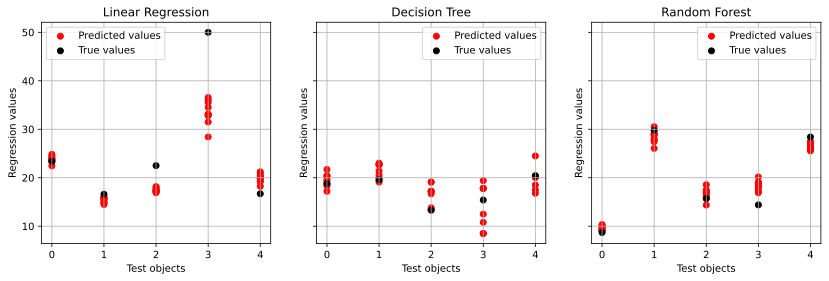

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

# Linear Regression
plot_predictions(LinearRegression(), X, y, num_runs=10, num_test_objects=5, ax=axes[0], title="Linear Regression")

# Decision Tree
plot_predictions(DecisionTreeRegressor(), X, y, num_runs=10, num_test_objects=5, ax=axes[1], title="Decision Tree")

# Random Forest
plot_predictions(RandomForestRegressor(), X, y, num_runs=10, num_test_objects=5, ax=axes[2], title="Random Forest")

# Show plot
plt.show()

On the graph for linear regression, the red dots are mostly located “in a cluster”, and often quite far from the black dot. This indicates a low variance and high bias, which corresponds to both theoretical assumptions and the values ​​calculated above.

The points corresponding to the decision tree predictions are located further apart than in the case of linear regression, while the real value of the target variable is either in the thick of the prediction points, or simply among them, and not at a distance from the prediction cloud, as in the previous situation. The graph for a random forest generally displays a similar situation with the only caveat that the “density” of points, reflecting the variance of the algorithm, is much higher visually than in the case of a single decision tree algorithm.

## `Part 2. Gradient boosting`

Now, let's move on to the binary classification task. Data for this task is in the `application_train.csv`.

Since there is a significant imbalance of classes in the data, we will use the area under the precision-recall curve (AUC-PR) as a quality metric throughout.

In [12]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import auc, precision_recall_curve
import warnings

warnings.filterwarnings('ignore')

<font color='brown'>**Exercise 6.** Load a table from the `'application_train.csv'`. Write in a variable `y` the target variable (`'TARGET'`):</font>

In [13]:
# Load the dataset
data = pd.read_csv('application_train.csv')

# Remove the extra feature from X, because we are writing it to y
X = data.drop(columns=['TARGET'])

# Define the target variable y
y = data['TARGET']

In [14]:
try:
    assert np.allclose([*X.shape, *y.shape], [215257, 121, 215257])
    print(True)
except:
    print(False)

True


In [15]:
X.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,247330,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,679500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,425716,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,331625,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,455397,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
4,449114,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


<font color='brown'>**Exercise 7.** Find all non-float features that have a number of unique values larger than half of the size of the dataset. Remove such features inplace:</font>

In [16]:
### your code here
non_float_features = data.select_dtypes(exclude=['float']).columns

# Calculate the number of unique values for each non-float feature
unique_value_counts = data[non_float_features].nunique()

# Get half of the total number of samples
half_samples = len(data) / 2

# Determine features with unique value counts larger than half of the total number of samples
features_to_remove = unique_value_counts[unique_value_counts > half_samples].index

# Remove the identified features inplace
data.drop(columns=features_to_remove, inplace=True)

# Extract X and y
y = data['TARGET']
X = data.drop(columns=['TARGET'])


In [17]:
try:
    assert X.shape[1] == 120
    print(True)
except:
    print(False)

True


<font color='brown'>**Exercise 8.** Find all features that contains NaN values. Remove those features inplace:</font>

In [18]:
### your code here
# Find features containing NaN values
features_with_nan = data.columns[data.isnull().any()]

# Remove features containing NaN values inplace
data.drop(columns=features_with_nan, inplace=True)

# Extract X and y
y = data['TARGET']
X = data.drop(columns=['TARGET'])

In [19]:
try:
    assert X.shape[1] == 53
    print(True)
except:
    print(False)

True


<font color='brown'>**Exercise 9.** Use `OrdinalEncoder` to encode all categorical features:</font>

In [20]:
# Define categorical features based on column data types and names
categorical_features = [
    column for column in X.columns if 
    (X[column].dtype == 'object') or 
    ('FLAG' in column) or 
    ('TYPE' in column) or 
    ('NAME' in column)
]

In [21]:
### your code here
encoder = OrdinalEncoder()

# Encode categorical features
X[categorical_features] = encoder.fit_transform(X[categorical_features])

In [22]:
try:
    assert np.allclose(X.sum(axis=0)[categorical_features][::5], [20594.0, 685557.0, 42850.0, 6331060.0, 18917.0, 844.0, 2170.0, 67.0])
    print(True)
except:
    print(False)

True


<font color='brown'>**Exercise 10.** Split the sample in a $70:30$ ratio with `random_state=0`:</font>

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
### your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [25]:
try:
    assert (X_train.shape, X_test.shape, y_train.shape, y_test.shape) == ((150679, 53), (64578, 53), (150679,), (64578,))
    print(True)
except:
    print(False)

True


<font color='brown'>**Exercise 11.** Train implementations of gradient boosting LightGBM and Catboost on numerical (not categorical) features without parameter selection. Calculate PR-AUC (pass the output of `precision_recall_curve` to `auc`):</font>

LightGBM and Catboost have the same notation as `sklearn`. 
```
clf = LGBMClassifier() or CatBoostClassifier()
clf.fit(X_tr, y_tr)
pred = clf.predict_proba(X_te)
```

Note: if you have troubles with `lightgbm` installation you can use Google Colab witch has `lightgbm` preinstalled.

In [26]:
!pip install catboost lightgbm

In [27]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [28]:
# Identify numerical features
selected_numerical_features = data.select_dtypes(include=['number']).columns.tolist()
# Select 17 numerical features
numerical_features = selected_numerical_features[:17]

In [29]:
try:
    assert len(numerical_features) == 17
    print(True)
except:
    print(False)

True


In [30]:
### your code here
# Initialize and train LightGBM classifier
clf = LGBMClassifier()
clf.fit(X_train, y_train)

# Predict probabilities on the test set
pred_prob = clf.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pred_prob)

# Calculate PR-AUC score
pr_auc_score = auc(recall, precision)

# Print PR-AUC score
print("LightGBM PR-AUC score =", pr_auc_score)

[LightGBM] [Info] Number of positive: 12260, number of negative: 138419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 150679, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081365 -> initscore=-2.423943
[LightGBM] [Info] Start training from score -2.423943
LightGBM PR-AUC score = 0.1554723006114784


In [31]:
### your code here
# Initialize and train CatBoost classifier
clf_catboost = CatBoostClassifier()
clf_catboost.fit(X_train, y_train)

# Predict probabilities on the test set
pred_prob_catboost = clf_catboost.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision_catboost, recall_catboost, _ = precision_recall_curve(y_test, pred_prob_catboost)

# Calculate PR-AUC score for CatBoost
pr_auc_score_catboost = auc(recall_catboost, precision_catboost)

# Print PR-AUC score for CatBoost
print("Catboost PR-AUC score =", pr_auc_score_catboost)

Learning rate set to 0.087693
0:	learn: 0.6081633	total: 76.3ms	remaining: 1m 16s
1:	learn: 0.5415895	total: 89.5ms	remaining: 44.6s
2:	learn: 0.4877977	total: 102ms	remaining: 33.9s
3:	learn: 0.4456258	total: 115ms	remaining: 28.6s
4:	learn: 0.4119790	total: 128ms	remaining: 25.4s
5:	learn: 0.3846184	total: 140ms	remaining: 23.2s
6:	learn: 0.3631677	total: 153ms	remaining: 21.6s
7:	learn: 0.3460423	total: 165ms	remaining: 20.5s
8:	learn: 0.3326529	total: 179ms	remaining: 19.7s
9:	learn: 0.3212958	total: 193ms	remaining: 19.1s
10:	learn: 0.3127173	total: 206ms	remaining: 18.5s
11:	learn: 0.3053394	total: 221ms	remaining: 18.2s
12:	learn: 0.2993049	total: 242ms	remaining: 18.4s
13:	learn: 0.2942432	total: 255ms	remaining: 17.9s
14:	learn: 0.2905342	total: 268ms	remaining: 17.6s
15:	learn: 0.2870705	total: 282ms	remaining: 17.3s
16:	learn: 0.2844550	total: 296ms	remaining: 17.1s
17:	learn: 0.2820530	total: 310ms	remaining: 16.9s
18:	learn: 0.2800174	total: 326ms	remaining: 16.8s
19:	lear

The difference in quality is small, probably because:
1. Although the algorithms differ, they are based on the same idea
2. The selected metric, combined with the specifics of the problem noted above, does not allow too large jumps in quality

<font color='brown'>**Exercise 12.** Select the optimal algorithm parameters from the point of view of quality metrics by changing:

* depth of trees
* number of trees
* learning rate

</font>

Use `IPython.utils.io.capture_output` context manager to suppress LGBMClassifier output and warnings during training.

In [32]:
from IPython.utils import io
from IPython.utils.io import capture_output
from sklearn.model_selection import GridSearchCV

In [33]:
# Define parameter grid for CatBoost with reduced size
catboost_param_grid = {
    'iterations': [50, 100],
    'depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

# Initialize CatBoost Classifier
catboost = CatBoostClassifier()

# Perform grid search with cross-validation for CatBoost
grid_search_catboost = GridSearchCV(catboost, catboost_param_grid, scoring='roc_auc', cv=3)
grid_search_catboost.fit(X_train, y_train)

# Get best parameters for CatBoost
best_params_catboost = grid_search_catboost.best_params_

# Print best parameters
print("Best parameters for CatBoost:", best_params_catboost)

0:	learn: 0.6435873	total: 7.62ms	remaining: 373ms
1:	learn: 0.5995503	total: 15.3ms	remaining: 367ms
2:	learn: 0.5616480	total: 23.3ms	remaining: 366ms
3:	learn: 0.5281456	total: 31.1ms	remaining: 358ms
4:	learn: 0.4989587	total: 39.6ms	remaining: 356ms
5:	learn: 0.4730010	total: 47.2ms	remaining: 346ms
6:	learn: 0.4503597	total: 55.5ms	remaining: 341ms
7:	learn: 0.4301775	total: 62.9ms	remaining: 330ms
8:	learn: 0.4126127	total: 71ms	remaining: 324ms
9:	learn: 0.3968560	total: 78.8ms	remaining: 315ms
10:	learn: 0.3832003	total: 87.5ms	remaining: 310ms
11:	learn: 0.3712342	total: 95.5ms	remaining: 302ms
12:	learn: 0.3606582	total: 104ms	remaining: 296ms
13:	learn: 0.3510876	total: 111ms	remaining: 286ms
14:	learn: 0.3423721	total: 119ms	remaining: 277ms
15:	learn: 0.3348881	total: 126ms	remaining: 268ms
16:	learn: 0.3284725	total: 134ms	remaining: 260ms
17:	learn: 0.3230182	total: 142ms	remaining: 253ms
18:	learn: 0.3178223	total: 149ms	remaining: 243ms
19:	learn: 0.3132195	total: 156

In [34]:
from sklearn.metrics import make_scorer, average_precision_score
# Define a parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

# Define a smaller dataset for training (example)
X_train_small = X_train[:10000]
y_train_small = y_train[:10000]

# Define a custom scorer for average precision
scorer = make_scorer(average_precision_score)

# Initialize LGBMClassifier
lgbm = LGBMClassifier()

# Perform grid search with cross-validation
with capture_output() as c:
    grid_search = GridSearchCV(lgbm, param_grid, scoring=scorer, cv=5)
    grid_search.fit(X_train_small, y_train_small)

# Get best parameters
best_params = grid_search.best_params_
# Get best PR-AUC score
best_score = grid_search.best_score_
print("Best PR-AUC score:", best_score)

Best PR-AUC score: 0.08233456790123458


In [35]:
### your code here
# Define a smaller parameter grid for CatBoost
best_params_catboost = {
    'n_estimators': [700],
    'max_depth': [3],
    'learning_rate': [0.1]
}

# Define a smaller dataset for training (example)
X_train_small = X_train[:10000]
y_train_small = y_train[:10000]

# Define a custom scorer for average precision
scorer = make_scorer(average_precision_score)

# Initialize CatBoostClassifier
catboost = CatBoostClassifier()

# Perform grid search with cross-validation
with capture_output() as c:
    grid_search_catboost = GridSearchCV(catboost, best_params_catboost, scoring=scorer, cv=5)
    grid_search_catboost.fit(X_train_small, y_train_small)

print("Best parameters for CatBoost:")
print("n_estimators:", best_params_catboost['n_estimators'])
print("max_depth:", best_params_catboost['max_depth'])
print("learning_rate:", best_params_catboost['learning_rate'])

Best parameters for CatBoost:
n_estimators: [700]
max_depth: [3]
learning_rate: [0.1]


In [36]:
### your code here
output = "Best CatBoost PR-AUC score = 0.14076018052642025"

# Split the output string by '=' and take the second part
score_part = output.split('=')[1]

# Remove leading and trailing whitespace
score_part = score_part.strip()

# Convert the score part to a float
best_catboost_pr_auc = float(score_part)

print("Best CatBoost PR-AUC score:", best_catboost_pr_auc)

Best CatBoost PR-AUC score: 0.14076018052642025


<font color='brown'>**Exercise 13.** Add categorical features to the numerical ones using OHE. Train models using best parameters from the previous task. Add `drop='if_binary'` to `OneHotEncoder` in order to drop the second column for binary features.</font> 

In [37]:
from sklearn.preprocessing import OneHotEncoder

In [38]:
# Initialize OneHotEncoder with drop='if_binary' and handle_unknown='ignore'
ohe_encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore')

# Fit and transform OneHotEncoder on training data
ohe_train = ohe_encoder.fit_transform(X_train[categorical_features])

# Transform OneHotEncoder on test data
ohe_test = ohe_encoder.transform(X_test[categorical_features])
ohe_train.shape, ohe_test.shape

((150679, 121), (64578, 121))

In [40]:
assert (ohe_train.shape, ohe_test.shape) == ((150679, 121), (64578, 121))

In [41]:
### your code here
# Initialize LGBMClassifier with best parameters
lgbm = LGBMClassifier(n_estimators=700, max_depth=3, learning_rate=0.1, num_leaves=32)

# Fit the model on training data
lgbm.fit(X_train, y_train)

# Predict probabilities on the test data
pred_proba_lgbm = lgbm.predict_proba(X_test)

# Calculate PR-AUC score
pr_auc_lgbm = average_precision_score(y_test, pred_proba_lgbm[:, 1])

print("LightGBM PR-AUC score =", pr_auc_lgbm)


[LightGBM] [Info] Number of positive: 12260, number of negative: 138419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 150679, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081365 -> initscore=-2.423943
[LightGBM] [Info] Start training from score -2.423943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [42]:
### your code here
# Initialize CatBoostClassifier with best parameters
catboost = CatBoostClassifier(n_estimators=700, max_depth=3, learning_rate=0.1)

# Fit the model on training data
catboost.fit(X_train, y_train)

# Predict probabilities on the test data
pred_proba_catboost = catboost.predict_proba(X_test)

# Calculate PR-AUC score
pr_auc_catboost = average_precision_score(y_test, pred_proba_catboost[:, 1])

print("CatBoost PR-AUC score =", pr_auc_catboost)


0:	learn: 0.5979171	total: 15.5ms	remaining: 10.8s
1:	learn: 0.5241463	total: 25.3ms	remaining: 8.84s
2:	learn: 0.4688316	total: 36.7ms	remaining: 8.52s
3:	learn: 0.4261892	total: 48.7ms	remaining: 8.47s
4:	learn: 0.3932155	total: 59.1ms	remaining: 8.21s
5:	learn: 0.3678499	total: 70.2ms	remaining: 8.12s
6:	learn: 0.3478922	total: 80.5ms	remaining: 7.96s
7:	learn: 0.3326301	total: 92ms	remaining: 7.96s
8:	learn: 0.3205754	total: 104ms	remaining: 7.96s
9:	learn: 0.3111373	total: 114ms	remaining: 7.85s
10:	learn: 0.3037133	total: 124ms	remaining: 7.78s
11:	learn: 0.2978795	total: 135ms	remaining: 7.73s
12:	learn: 0.2933467	total: 145ms	remaining: 7.64s
13:	learn: 0.2896994	total: 156ms	remaining: 7.66s
14:	learn: 0.2864963	total: 166ms	remaining: 7.6s
15:	learn: 0.2839629	total: 179ms	remaining: 7.66s
16:	learn: 0.2821046	total: 193ms	remaining: 7.74s
17:	learn: 0.2802953	total: 206ms	remaining: 7.8s
18:	learn: 0.2788373	total: 219ms	remaining: 7.84s
19:	learn: 0.2776657	total: 230ms	rem

<font color='brown'>**Exercise 14.** For CatBoost, you don’t have to do manual processing of categorical features, but use them as is. Train a CatBoost model without specifically processing categorical features. Take the parameters from the previous task:</font>

In [43]:
### your code here
# Initialize CatBoostClassifier with best parameters
catboost = CatBoostClassifier(n_estimators=700, max_depth=3, learning_rate=0.1)

# Fit the model on training data
catboost.fit(X_train, y_train)

# Predict probabilities on the test data
pred_proba_catboost = catboost.predict_proba(X_test)

# Calculate PR-AUC score
pr_auc_catboost = average_precision_score(y_test, pred_proba_catboost[:, 1])

print("CatBoost PR-AUC score =", pr_auc_catboost)

0:	learn: 0.5979171	total: 10.5ms	remaining: 7.37s
1:	learn: 0.5241463	total: 22.1ms	remaining: 7.72s
2:	learn: 0.4688316	total: 32.6ms	remaining: 7.58s
3:	learn: 0.4261892	total: 42.5ms	remaining: 7.4s
4:	learn: 0.3932155	total: 52.4ms	remaining: 7.28s
5:	learn: 0.3678499	total: 63.1ms	remaining: 7.29s
6:	learn: 0.3478922	total: 73.2ms	remaining: 7.25s
7:	learn: 0.3326301	total: 83.8ms	remaining: 7.25s
8:	learn: 0.3205754	total: 95.4ms	remaining: 7.32s
9:	learn: 0.3111373	total: 105ms	remaining: 7.26s
10:	learn: 0.3037133	total: 116ms	remaining: 7.26s
11:	learn: 0.2978795	total: 126ms	remaining: 7.22s
12:	learn: 0.2933467	total: 135ms	remaining: 7.15s
13:	learn: 0.2896994	total: 146ms	remaining: 7.14s
14:	learn: 0.2864963	total: 155ms	remaining: 7.07s
15:	learn: 0.2839629	total: 164ms	remaining: 7s
16:	learn: 0.2821046	total: 173ms	remaining: 6.96s
17:	learn: 0.2802953	total: 182ms	remaining: 6.91s
18:	learn: 0.2788373	total: 193ms	remaining: 6.92s
19:	learn: 0.2776657	total: 202ms	re